**Tijuana house prediction price**

In [117]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# from geopy.distance import geodesic
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import  r2_score
from scipy.stats import skew #for some statistics
import warnings
warnings.filterwarnings('ignore')




In [118]:
url = 'https://raw.githubusercontent.com/IvanVC21/Tijuana-house-prices/main/tijuana_prices.csv'
df = pd.read_csv(url)

In [119]:
df.head()

,price,currency,bedrooms,bathrooms,parkingSpots,propertySize,neighborhood,lat,lon
0,150000.0,USD,4.0,2.0,3.0,130.0,"Las Americas, Tijuana",32.500975,-116.896457
1,774900.0,USD,3.0,3.0,2.0,550.0,"Hacienda Agua Caliente, Tijuana",32.488683,-116.999223
2,3000000.0,MN,3.0,2.0,2.0,107.0,"Lomas de La Presa, Tijuana",32.448786,-116.924895
3,385000.0,USD,4.0,3.0,3.0,350.0,"Xicotencatl Leyva, Tijuana",32.538363,-116.931519
4,70000.0,USD,2.0,1.0,1.0,80.0,"Vaim, Tijuana",32.493642,-116.942191


In [120]:
df.shape

(888, 9)

In [121]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 888 entries, 0 to 887
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         887 non-null    float64
 1   currency      887 non-null    object 
 2   bedrooms      877 non-null    float64
 3   bathrooms     867 non-null    float64
 4   parkingSpots  799 non-null    float64
 5   propertySize  885 non-null    float64
 6   neighborhood  888 non-null    object 
 7   lat           888 non-null    float64
 8   lon           888 non-null    float64
dtypes: float64(7), object(2)
memory usage: 62.6+ KB


In [122]:
df_price = df.copy()

**Turn mexicans pesos into USD**

In [123]:
mask = df_price['currency'] == 'MN'
df_price['price'] = np.where(mask,df_price['price']/20,df_price['price'])
df_price.drop('currency', axis=1, inplace=True)

In [124]:
df_price.head()

,price,bedrooms,bathrooms,parkingSpots,propertySize,neighborhood,lat,lon
0,150000.0,4.0,2.0,3.0,130.0,"Las Americas, Tijuana",32.500975,-116.896457
1,774900.0,3.0,3.0,2.0,550.0,"Hacienda Agua Caliente, Tijuana",32.488683,-116.999223
2,150000.0,3.0,2.0,2.0,107.0,"Lomas de La Presa, Tijuana",32.448786,-116.924895
3,385000.0,4.0,3.0,3.0,350.0,"Xicotencatl Leyva, Tijuana",32.538363,-116.931519
4,70000.0,2.0,1.0,1.0,80.0,"Vaim, Tijuana",32.493642,-116.942191


In [125]:
df_price.describe()

,price,bedrooms,bathrooms,parkingSpots,propertySize,lat,lon
count,8.870000e+02,877.000000,867.000000,799.000000,885.000000,888.000000,888.000000
mean,2.350548e+05,3.052452,2.438293,2.445557,259.010169,32.496347,-117.008395
std,3.066921e+05,0.920087,1.244595,7.107074,848.497535,0.029580,0.067410
min,8.250000e+03,1.000000,1.000000,1.000000,1.000000,32.389551,-117.123031
25%,8.600000e+04,3.000000,2.000000,2.000000,102.000000,32.483423,-117.038247
50%,1.540000e+05,3.000000,2.000000,2.000000,138.000000,32.511290,-117.038247
75%,2.825000e+05,3.000000,3.000000,2.000000,225.000000,32.514947,-116.977558
max,3.950000e+06,12.000000,15.000000,200.000000,15976.000000,32.559473,-116.733438


In [126]:
def missing_data_df(df):
    
    missing_data = pd.concat([df.isnull().sum(),
                              df.isnull().mean()*100],
                              axis=1,
                              keys=["Missing_Data","Percent"]
                            )
    missing_data = missing_data.sort_values("Percent", 
                                            ascending=False,
                                           )
    return missing_data


**Percent of missing data in each column**

In [127]:
missing_data_df(df_price)

,Missing_Data,Percent
parkingSpots,89,10.022523
bathrooms,21,2.364865
bedrooms,11,1.238739
propertySize,3,0.337838
price,1,0.112613
neighborhood,0,0.000000
lat,0,0.000000
lon,0,0.000000


In [128]:
(df_price['bathrooms']
.value_counts(ascending=False)
)

2.0     372
3.0     227
1.0     157
4.0      71
5.0      20
7.0      11
6.0       5
8.0       2
15.0      1
10.0      1
Name: bathrooms, dtype: int64

**Preprocessing data**

In [129]:
df_price['parkingSpots'].fillna(0,inplace=True)
df_price['bathrooms'].fillna(df_price['bathrooms'].mode().iloc[0],inplace=True)
df_price['bedrooms'].fillna(df_price['bedrooms'].mode().iloc[0],inplace=True)
df_price['propertySize'].fillna(df_price['propertySize'].median(),inplace=True)
df_price['price'].fillna(df_price['price'].median(),inplace=True)
df_price['price'].fillna(df_price['price'].median(),inplace=True)

In [130]:
(df_price
    .groupby('parkingSpots')['price']
    .apply(lambda x: x.mean())
    .sort_values(ascending=False)
)

parkingSpots
7.0      2.465000e+06
6.0      6.530000e+05
20.0     6.500000e+05
5.0      6.418043e+05
8.0      4.760000e+05
4.0      4.042581e+05
3.0      4.006161e+05
0.0      2.527432e+05
10.0     2.150000e+05
2.0      2.011418e+05
1.0      8.142765e+04
200.0    1.400000e+04
Name: price, dtype: float64

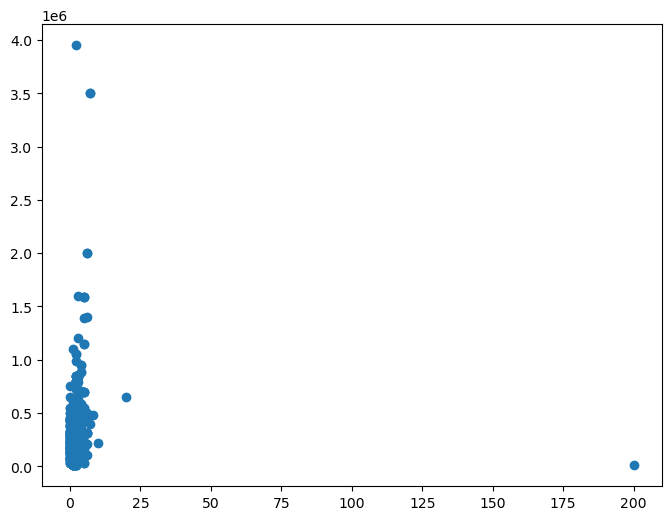

In [131]:
fig = plt.figure(figsize=(8,6))
plt.scatter(df_price['parkingSpots'],df_price['price'])
plt.show()

<Figure size 800x600 with 0 Axes>

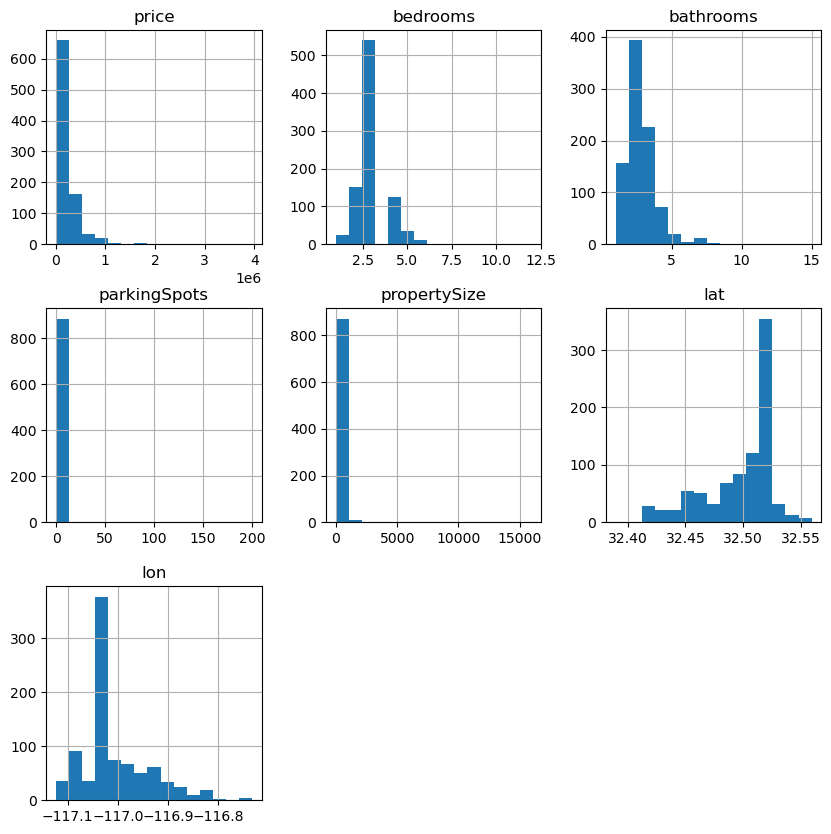

In [132]:
fig = plt.figure(figsize=(8,6))
df_price.hist(bins = 15,figsize=(10,10))
plt.show()


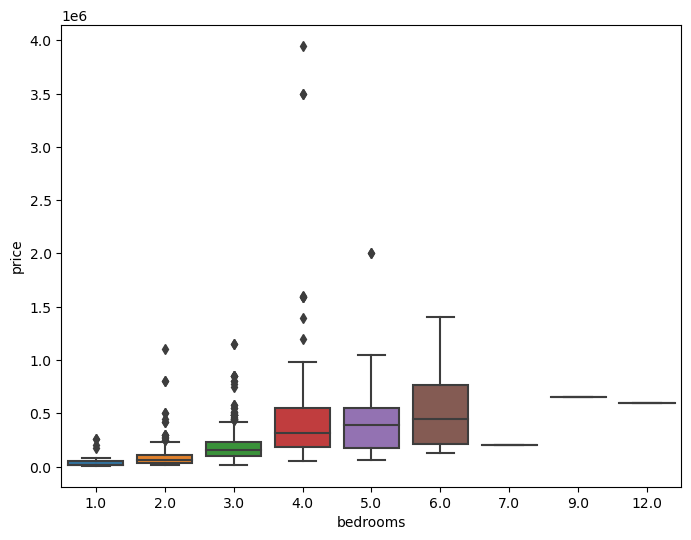

In [133]:
var = 'bedrooms'
data = pd.concat([df_price['price'], df_price[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x = var, y  = 'price', data=data);

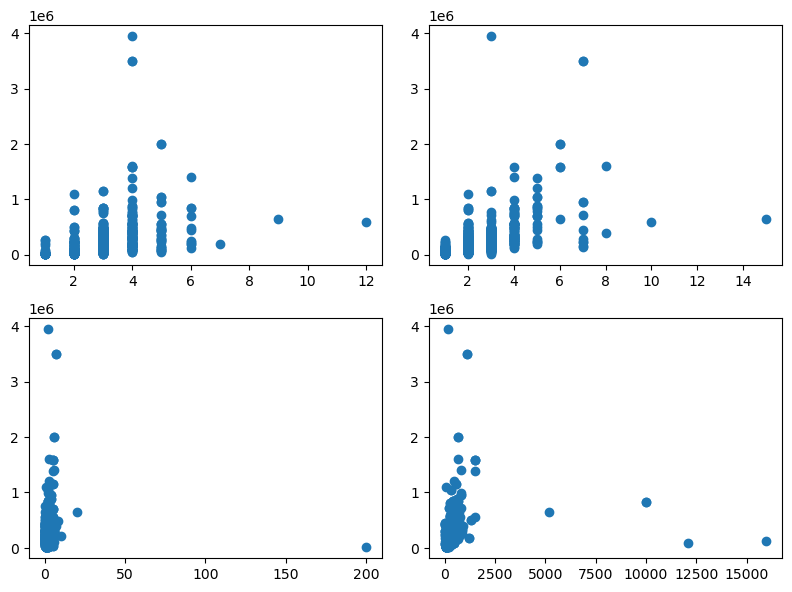

In [134]:
columns = ['bedrooms','bathrooms','parkingSpots','propertySize']
index = 1
fig = plt.figure(figsize=(8,6))
for col in columns:
    plt.subplot(2,2,index)
    plt.scatter(df_price[col], df_price['price'])
    index = index + 1
fig.tight_layout(pad=1.0)

In [135]:
mask_spots = df_price['parkingSpots']>150
mask_Size = df_price['propertySize']>4000

value  = df_price[mask_spots].index.values
col_out = df_price[mask_Size].index.values
df_price.loc[value,'parkingSpots'] = df_price['parkingSpots'].mode().loc[0]

df_price.loc[col_out,'propertySize'] = df_price['propertySize'].median()

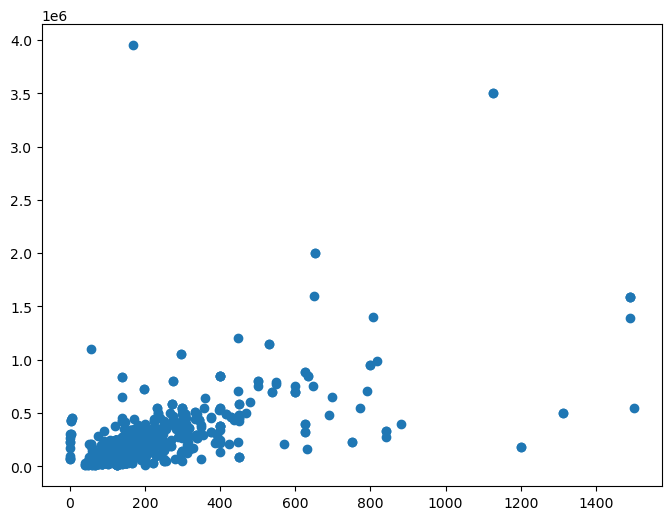

In [136]:
fig = plt.figure(figsize=(8,6))
plt.scatter(df_price.propertySize,df_price.price)
plt.show()

In [137]:
correlation = df_price.corr().abs()
correlation.where(np.triu(correlation,k=1).astype(np.bool),0)

,price,bedrooms,bathrooms,parkingSpots,propertySize,lat,lon
price,0.0,0.371323,0.543327,0.361825,0.612625,0.023835,0.139960
bedrooms,0.0,0.000000,0.622012,0.325982,0.342538,0.057412,0.087200
bathrooms,0.0,0.000000,0.000000,0.441673,0.447635,0.057402,0.208644
parkingSpots,0.0,0.000000,0.000000,0.000000,0.377456,0.013431,0.063497
propertySize,0.0,0.000000,0.000000,0.000000,0.000000,0.020022,0.051998
lat,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.054947
lon,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


**Manage_Location**

In [138]:
# loc_ref = (32.524893,-117.116085)   # Referencia Playa
# df_price['loc'] = df_price.apply(lambda df: (df['lat'],df['lon']), axis=1)
# # df_price['dist'] = df_price['loc'].apply(lambda x: GRC(x,loc_ref).km)
# df_price['dist'] = df_price['loc'].apply(lambda x: geodesic(x,loc_ref).km)


In [139]:
# columns = ['lat','lon','neighborhood']
# df_price.drop(columns=columns, axis=1,inplace=True)

In [140]:
df_price.head()

,price,bedrooms,bathrooms,parkingSpots,propertySize,neighborhood,lat,lon
0,150000.0,4.0,2.0,3.0,130.0,"Las Americas, Tijuana",32.500975,-116.896457
1,774900.0,3.0,3.0,2.0,550.0,"Hacienda Agua Caliente, Tijuana",32.488683,-116.999223
2,150000.0,3.0,2.0,2.0,107.0,"Lomas de La Presa, Tijuana",32.448786,-116.924895
3,385000.0,4.0,3.0,3.0,350.0,"Xicotencatl Leyva, Tijuana",32.538363,-116.931519
4,70000.0,2.0,1.0,1.0,80.0,"Vaim, Tijuana",32.493642,-116.942191


In [141]:
col_num = ['propertySize', 'price']
numeric_feature = df_price[col_num].apply(lambda x: skew(x)).sort_values(ascending=False)
skewness = pd.DataFrame(numeric_feature,columns=['Skew'])
# lam=0.13
for col in skewness.index:
    # df_price[col] = boxcox1p(df_price[col], lam)
    df_price[col] = np.log1p(df_price[col])

In [142]:
y = df_price['price'].values
X = df_price.drop(['price', 'neighborhood'], axis=1)

In [143]:
X.head()

,bedrooms,bathrooms,parkingSpots,propertySize,lat,lon
0,4.0,2.0,3.0,4.875197,32.500975,-116.896457
1,3.0,3.0,2.0,6.311735,32.488683,-116.999223
2,3.0,2.0,2.0,4.682131,32.448786,-116.924895
3,4.0,3.0,3.0,5.860786,32.538363,-116.931519
4,2.0,1.0,1.0,4.394449,32.493642,-116.942191


In [144]:
scaler = RobustScaler()
X_transform = scaler.fit_transform(X)
X_train,X_test,y_train,y_test = train_test_split(X_transform,y,test_size=0.15,random_state=42)

X_train.shape , X_test.shape , y_train.shape , y_test.shape

((754, 6), (134, 6), (754,), (134,))

In [145]:
import xgboost
regressor=xgboost.XGBRegressor()

In [146]:
base_score=[0.15, 0.2,0.25]

n_estimators = [850, 900, 950]
max_depth = [2, 3, 5, 10, 15]
booster=['gbtree']
learning_rate=[0.03, 0.05,0.1]
min_child_weight=[1,2,3,4]

hyperparameter_grid = {
    'n_estimators': n_estimators,
    'max_depth':max_depth,
    'learning_rate':learning_rate,
    'min_child_weight':min_child_weight,
    'booster':booster,
    'base_score':base_score
     }

In [147]:
from sklearn.model_selection import RandomizedSearchCV

random_cv = RandomizedSearchCV(estimator=regressor,
            param_distributions=hyperparameter_grid,
            cv=5, 
            n_iter=50,
            scoring = 'neg_mean_absolute_error', 
            n_jobs=4,
            random_state=42
            )
random_cv.fit(X_train,y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          enable_categorical=False, gamma=None,
                                          gpu_id=None, importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=...
                                          scale_pos_weight=None, subsample=None,
                                          tree_method=None,
                                          validate

In [148]:
best_xgb = random_cv.best_estimator_
best_xgb

XGBRegressor(base_score=0.25, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=10, min_child_weight=3, missing=nan,
             monotone_constraints='()', n_estimators=950, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

**R2 metrics between predicted and real output value respectively**

In [149]:
y_test_pred = best_xgb.predict(X_test)
y_test_pred = np.expm1(y_test_pred)
y_test = np.expm1(y_test)


r2 = r2_score(y_test,y_test_pred)
print(r2)

0.8833864907470141
